Neste notebook são testados vários pesos, ou seja, várias tentativas de alocações de carteira com objetivo de encontrar a combinação com o maior sharpe ratio. Para esse índice é considerada a relação entre retornos e volatilidade. Quanto maior o retorno e menor a volatilidade, maior o Sharpe Ratio.

O Sharpe Ratio é a medida mais importante de risco/retorno utilizada em finanças. Descreve o quanto de excesso de retorno estamos recebenbo para extra volatidade ao utilizar uma ação com risco.

$$ SR(x) = \frac{r_x - R_f}{\sigma_x}$$

onde $ r_x $ é a média de retorno do investimento x, $ R_f $ é a taxa de retorno livre de riscos, e $ \sigma_x $ é o desvio padrão dos retornos do investimento.

In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

np.random.seed(0)

In [2]:
# em média, 252 dias úteis no ano
NUM_TRADING_DAYS = 252
# vamos gerar w aleatórios (diferentes portfólios)
NUM_PORTFOLIOS = 10000

## Carregamento dos dados

In [3]:
# os papeis que utilizaremos
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']

In [4]:
# definir início e fim dos dados históricos
start_date = '2015-01-01'
end_date = '2022-01-01'

In [5]:
# download dos dados
stock_data = {}

for stock in stocks:
    # utilizaremos o processo de fechamento
    ticker = yf.Ticker(stock)
    stock_data[stock] = ticker.history(start = start_date, end = end_date)['Close']

dataset = pd.DataFrame(stock_data)

In [6]:
dataset

,AAPL,WMT,TSLA,GE,AMZN,DB
Date,,,,,,
2015-01-02,24.714508,72.724808,43.862000,166.907059,308.519989,28.759422
2015-01-05,24.018259,72.513153,42.018002,163.843384,302.190002,27.202053
2015-01-06,24.020519,73.071938,42.256001,160.313385,295.290009,26.767879
2015-01-07,24.357342,75.010704,42.189999,160.380035,298.420013,27.051037
2015-01-08,25.293207,76.593864,42.124001,162.311478,300.459991,27.107668
...,...,...,...,...,...,...
2021-12-27,180.100540,140.217682,1093.939941,94.535088,3393.389893,12.780000
2021-12-28,179.061859,142.229904,1088.469971,95.214478,3413.219971,12.700000
2021-12-29,179.151749,142.160172,1086.189941,94.704933,3384.020020,12.590000


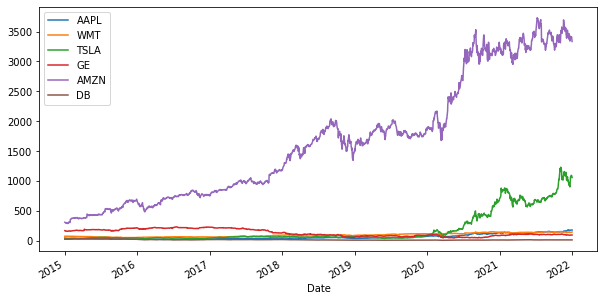

In [7]:
dataset.plot(figsize=(10, 5))
plt.show()

<AxesSubplot:xlabel='Date'>

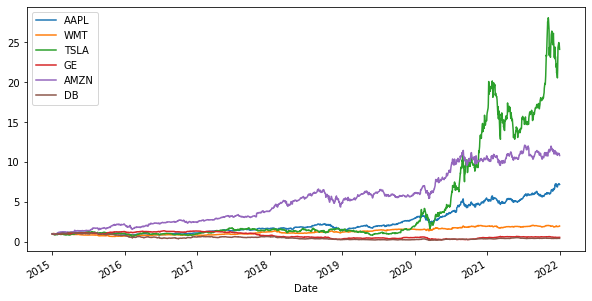

In [8]:
(dataset / dataset.iloc[0]).plot(figsize=(10,5))

## Normalização dos dados e cálculo dos retornos

In [9]:
# normalização - medir todas as variáveis em métrica comparável - log
log_return = np.log(dataset / dataset.shift(1)) # S(t+1) / S(t)
log_daily_returns = log_return[1:] # desconsiderando a primeira linha

In [10]:
# em vez de métricas diárias, buscamos métricas anuais
# média de retorno anual 
print(log_daily_returns.mean() * NUM_TRADING_DAYS)
print(log_daily_returns.cov() * NUM_TRADING_DAYS)
# temos um retorno médio anual de 20% na apple, 33% na tela e no DB se perde dinheiro

AAPL    0.281848
WMT     0.097832
TSLA    0.455078
GE     -0.081529
AMZN    0.340421
DB     -0.119169
dtype: float64
          AAPL       WMT      TSLA        GE      AMZN        DB
AAPL  0.084363  0.020902  0.062266  0.034261  0.048750  0.038670
WMT   0.020902  0.045249  0.019046  0.013616  0.016171  0.015352
TSLA  0.062266  0.019046  0.301876  0.043191  0.058748  0.053680
GE    0.034261  0.013616  0.043191  0.135583  0.021589  0.065871
AMZN  0.048750  0.016171  0.058748  0.021589  0.089424  0.030884
DB    0.038670  0.015352  0.053680  0.065871  0.030884  0.170190


## Gerando carteiras para 10000 pesos aleatórios

In [11]:
portfolio_means = []
portfolio_risks = []
portfolio_weights = []

for _ in range(NUM_PORTFOLIOS):
    w = np.random.random(len(stocks))
    w /= np.sum(w) # normalizing

    mean = np.sum(log_daily_returns.mean() * w) * NUM_TRADING_DAYS
    risk = np.sqrt(np.dot(w.T, np.dot(log_daily_returns.cov() * NUM_TRADING_DAYS, w))) # W.T*(COV)*W

    portfolio_weights.append(w)
    portfolio_means.append(mean)
    portfolio_risks.append(risk)

pweights, means, risks = np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

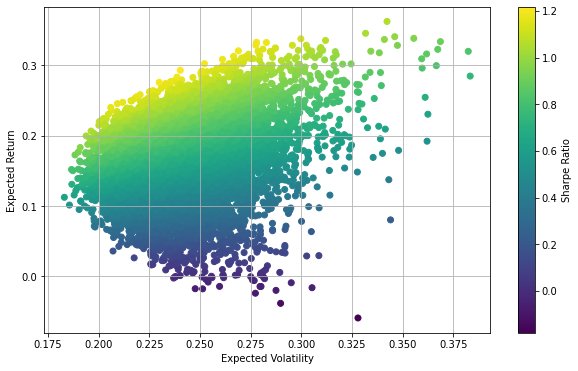

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(risks, means, c=means/risks, marker = 'o')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.show()

## Otimização para encontrar carteira ótima

In [13]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean()*weights) * NUM_TRADING_DAYS
    portfolio_volatility =  np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    
    return np.array([portfolio_return, portfolio_volatility, sharpe_ratio])

In [14]:
# scipy optimize encontra o mínimo de uma função
# o máximo de f(x) é o mínimo de -f(x)

def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2] # índice de Sharpe

In [15]:
# f(x) = 0 é a função que minimizaremos, que no caso é o índice Sharpe

# restrição: a soma dos pesos = 1 
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1 }

# os pesos podem ser 1 no máximo: 1 quando 100% do dinheiro é investido em uma única ação
bounds = [tuple((0, 1)) for _ in range(len(stocks))] # [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

optimum =  optimization.minimize(fun = min_function_sharpe, x0 = pweights[0], args = log_daily_returns, method='SLSQP', bounds = bounds, constraints = constraints)

In [16]:
print('Carteira ótima: ', optimum['x'].round(3))
print('Retorno esperado, volatilidade e índice Sharpe: ', statistics(optimum['x'].round(3), log_daily_returns))

Carteira ótima:  [0.246 0.075 0.148 0.    0.531 0.   ]
Retorno esperado, volatilidade e índice Sharpe:  [0.32478706 0.25723987 1.26258444]


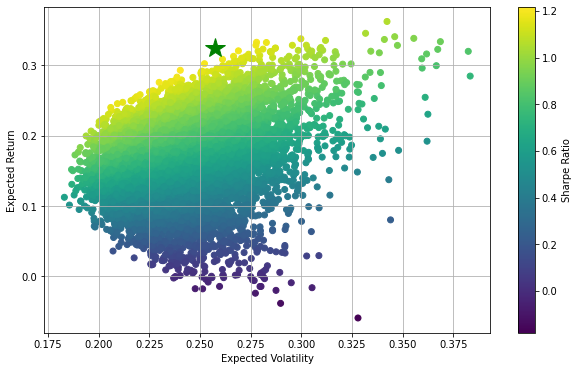

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(risks, means, c=means / risks, marker = 'o')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.plot(statistics(optimum['x'], log_daily_returns)[1], statistics(optimum['x'], log_daily_returns)[0], 'g*', markersize=20.0)
plt.show()